In [534]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from tqdm import tqdm


## Reading Data

In [535]:
data = np.genfromtxt('../data/california.csv', delimiter=',')
data = torch.Tensor(data)
data[:5]

tensor([[ 4.1685e+00,  2.0000e+01,  6.7006e+00,  1.1783e+00,  7.4500e+02,
          2.3726e+00,  3.8800e+01, -1.2115e+02,  2.1750e+00],
        [ 2.8194e+00,  2.4000e+01,  4.7625e+00,  1.0208e+00,  6.0800e+02,
          2.5333e+00,  3.6750e+01, -1.1985e+02,  8.1100e-01],
        [ 2.4250e+00,  4.6000e+01,  4.9277e+00,  1.0181e+00,  7.7200e+02,
          2.3253e+00,  3.6330e+01, -1.1931e+02,  8.4900e-01],
        [ 3.1205e+00,  1.6000e+01,  3.7285e+00,  1.1015e+00,  1.2600e+03,
          2.7815e+00,  3.3870e+01, -1.1799e+02,  1.7400e+00],
        [ 4.3889e+00,  4.1000e+01,  5.7410e+00,  1.1990e+00,  8.3700e+02,
          2.0072e+00,  3.4150e+01, -1.1840e+02,  3.8040e+00]])

In [537]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [540]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(data, 0.8)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

## Model

In [543]:
class PyTorchLR(nn.Module):
    def __init__(self, n_explanatory_features):
        super(PyTorchLR, self).__init__()
        self.coefs = nn.Parameter(
            torch.randn(n_explanatory_features).type(torch.float32).unsqueeze(1), 
            requires_grad=True
        )
        
        self.intercept = nn.Parameter(
            torch.randn(1).type(torch.float32), 
            requires_grad=True
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return X @ self.coefs + self.intercept

# Training Loop

100%|██████████| 8001/8001 [00:04<00:00, 1631.57it/s]


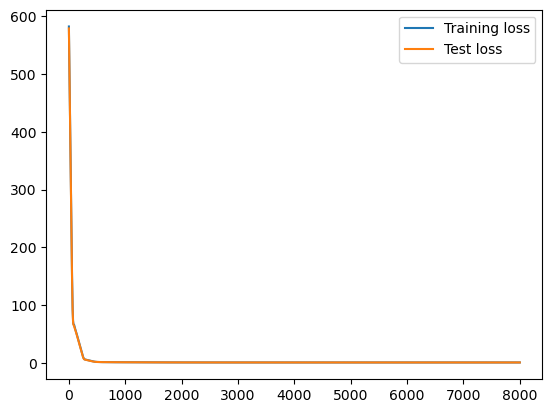

In [572]:
torch.random.manual_seed(718274)

model = PyTorchLR(n_explanatory_features=X_train.shape[1]).to(device)

loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loss_list = []
test_loss_list = []

for epoch in tqdm(range(8_001)):
    
    model.train()

    y_pred = model(X_train)

    loss = loss_function(y_pred, y_train)
    train_loss_list.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_test_pred = model(X_test).to(device)

        test_loss = loss_function(y_test_pred, y_test)
        test_loss_list.append(test_loss.item())


plt.plot(train_loss_list, label='Training loss')
plt.plot(test_loss_list, label='Test loss')
plt.legend()
plt.show()

In [573]:
y_pred = model(X_test).detach().cpu().numpy()
print('MAE: {}\nMSE: {}\nRMSE: {}'.format(
    mean_absolute_error(y_test.cpu().numpy(), y_pred),
    mean_squared_error(y_test.cpu().numpy(), y_pred),
    mean_squared_error(y_test.cpu().numpy(), y_pred, squared=False)
    )
)

MAE: 0.6194950938224792
MSE: 0.6382973790168762
RMSE: 0.7989351749420166


In [556]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train.cpu().numpy(), y_train.cpu().numpy())


y_pred = lr.predict(X_test.cpu().numpy())

print(lr.coef_)

print('MAE: {}\nMSE: {}\nRMSE: {}'.format(
    mean_absolute_error(y_test.cpu().numpy(), y_pred),
    mean_squared_error(y_test.cpu().numpy(), y_pred),
    mean_squared_error(y_test.cpu().numpy(), y_pred, squared=False)
    )
)

[[ 4.5171490e-01  1.1028232e-02 -1.3925108e-01  9.2565882e-01
  -7.4341265e-06 -3.4714523e-03 -4.1473499e-01 -4.2809570e-01]]
MAE: 0.5292350649833679
MSE: 0.5195268392562866
RMSE: 0.7207821011543274
